In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install facenet_pytorch

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 54.3MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 1.9MB 8.6MB/s 


In [3]:
!mkdir -p /content/data

In [4]:
!cp /content/drive/MyDrive/PyTorch/hand/archive.zip /content/data/data.zip

In [5]:
!unzip -q /content/data/data.zip -d /content/data/

In [6]:
!pip install facenet_pytorch

In [7]:
import os
import torch
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import time
from torch.autograd import Variable
import pandas as pd
from PIL import Image
import random
from matplotlib import image
import shutil
from sklearn.model_selection import train_test_split
import cv2
from facenet_pytorch import MTCNN
from IPython import display
from sklearn.metrics import accuracy_score

In [8]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [9]:
transforms = tt.Compose([tt.Grayscale(num_output_channels=1), tt.CenterCrop(240), tt.Resize(64), tt.ToTensor()])
for folder in os.listdir('/content/data/leapGestRecog'):
    images = ImageFolder(os.path.join('/content/data/leapGestRecog', folder), transforms)

In [10]:
images

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/data/leapGestRecog/08
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               CenterCrop(size=(240, 240))
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [11]:
X_train, X_test = train_test_split(images, test_size = 0.3, random_state = 42)

In [12]:
train_data_loader = DataLoader(X_train, batch_size=32, shuffle=True)
test_data_loader = DataLoader(X_test, batch_size=16)

torch.Size([1, 64, 64])


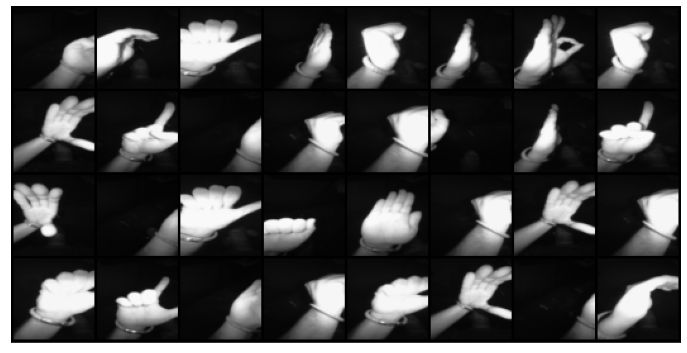

In [13]:
def showbatch(batch):
    for images, labels in batch:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

showbatch(train_data_loader)

In [14]:
class Hand_Classifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_block(1, 32, pool=False)
        self.conv2 = self.conv_block(32, 32, pool=True)
        self.conv3 = self.conv_block(32, 64, pool=True)
        self.drop = nn.Dropout(0.3)
        self.dense = nn.Sequential(nn.Flatten(), 
                                   nn.Linear(64*6*6, 256), 
                                   nn.ReLU(inplace=True), 
                                   nn.Linear(256, 10), 
                                   nn.Softmax(dim=1)
                                  )
        
    @staticmethod
    def conv_block(in_feat, out_feat, pool=False):
        layers = [nn.Conv2d(in_feat, out_feat, kernel_size=3), nn.ReLU(inplace=True)]
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=3))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.drop(out)
        out = self.conv3(out)
        out = self.drop(out)
        out = self.dense(out)
        
        return out

In [15]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cuda')

In [16]:
def accuracy(pred, true):
    pred = np.argmax(pred.to('cpu').detach().numpy(), axis=1)
    true = true.to('cpu').detach().numpy()
    return len(np.where(pred==true)[0])/len(true)

In [17]:
hс = Hand_Classifier()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(hс.parameters(), lr=0.001, weight_decay=1e-6)

In [19]:
hс.to(device)

Hand_Classifier(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout(p=0.3, inplace=False)
  (dense): Sequential(
    (0): Flatten()
    (1): Linear(in_features=2304, out_features=256, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

In [20]:
train_loss_history = []
accuracy_history = []

for epoch in range(40):
    epoch_accuracy = []
    epoch_loss = []
    for images, labels in train_data_loader:
        
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
        outputs = hс(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        epoch_accuracy.append(accuracy(outputs, labels))
    
    train_loss_history.append(np.mean(epoch_loss))
    accuracy_history.append(np.mean(epoch_accuracy))
    print(f'Epoch {epoch+1}, loss: {np.mean(epoch_loss)}, accuracy: {np.mean(epoch_accuracy)}')

Epoch 1, loss: 2.0370611277493564, accuracy: 0.40767045454545453
Epoch 2, loss: 1.6013004942373796, accuracy: 0.8676609848484849
Epoch 3, loss: 1.5361988761208274, accuracy: 0.925189393939394
Epoch 4, loss: 1.5124235884709791, accuracy: 0.953125
Epoch 5, loss: 1.5027303912422874, accuracy: 0.9583333333333333
Epoch 6, loss: 1.4965269619768315, accuracy: 0.9651988636363636
Epoch 7, loss: 1.500218082558025, accuracy: 0.9616477272727273
Epoch 8, loss: 1.495643973350525, accuracy: 0.9670928030303031
Epoch 9, loss: 1.485287831588225, accuracy: 0.9763257575757577
Epoch 10, loss: 1.4845691404559396, accuracy: 0.9758522727272727
Epoch 11, loss: 1.481047267263586, accuracy: 0.979876893939394
Epoch 12, loss: 1.478509247303009, accuracy: 0.9829545454545454
Epoch 13, loss: 1.477439121766524, accuracy: 0.9850852272727273
Epoch 14, loss: 1.478165328502655, accuracy: 0.9836647727272727
Epoch 15, loss: 1.4748776257038116, accuracy: 0.9857954545454546
Epoch 16, loss: 1.4733294302766973, accuracy: 0.9886

In [21]:
savePATH = '/content/drive/MyDrive/PyTorch/hw5-hc.pth'
torch.save(hс.state_dict(), savePATH)